## Lazy A* ##

In this lab we are going to implement a *Lazy* variant of the A* algorithm. 

'Lazy' in general means that we are post-poning some computations until absolutely necessarily.

In particular, in this lab we postpone *edge evaluations*. 

In vanilla A*, when the node <i>s</i> is expanded all outgoing edges are evaluated i.e. we compute the cost of traversing these edges and use these true edges costs to compute the <i>g</i>-values of the succesors of <i>s</i>.

In certain domains edge evaluations are costly (in a sense that it might take quite a time to figure out the true cost of an edge as it might involve complex validation routines (e.g. collision checking)). Thus it is reasonable to evaluate them *lazily*.

More precisely, when expanding a node <i>s</i> and generating its succesors*'* we are approximating their <i>g</i>-values as follows:

*g(s')=g(s)+apr_cost(s,s')*,

where *apr_cost* is the easy-to-compute conservative approximation of the true cost, i.e. *apr_cost <= true_cost*.

We will compute the true cost of the edge *(s, s')* only when *s'* will be chosen for an expansion. This will likely lead to re-computing *g(s)* and re-inserting *s'* to *OPEN*.

Overall, such a trick will save us time (as we will see in this lab).


PS: Some papers describing the different variant of lazy search are the following:
TO BE ADDED SOON =)



In [1]:
import random

from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from random import randint, random, seed
from heapq import heappop, heappush
from time import sleep

### Grid map representation 

Square grid map class represents the environment for our moving agent

- width -- the number of columns in the grid
- height -- the number of rows in the grid
- cells -- the binary matrix, that represents the grid. 0 - cell is traversable, 1 - cell is blocked

In [2]:
class Map:

    def __init__(self):
        """
        Default constructor
        """

        self._width = 0
        self._height = 0
        self._cells = []

    def read_from_string(self, cell_str, width, height):
        """
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        """
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '#':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width)

                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height)

    def set_grid_cells(self, width, height, grid_cells):
        """
        Initialization of map by list of cells.
        """
        self._width = width
        self._height = height
        self._cells = grid_cells

    def in_bounds(self, i, j):
        """
        Check if the cell is on a grid.
        """
        return (0 <= j < self._width) and (0 <= i < self._height)

    def traversable(self, i, j):
        """
        Check if the cell is not an obstacle.
        """
        return not self._cells[i][j]

    def get_neighbors(self, i, j):
        """
        Get a list of neighbouring cells as (i,j) tuples.
        It's assumed that grid is 8-connected (i.e. movements in cardinal and diagonal directions are allowed)
        """
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]

        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
                
        delta = [[1, 1], [1, -1], [-1, -1], [-1, 1]]
        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]) and self.traversable(i, j + d[1]) and self.traversable(i + d[0], j):
                neighbors.append((i + d[0], j + d[1]))

        return neighbors

    def get_size(self):
        return self._height, self._width

## Evaluating edges

Here is the crux of the Lazy A*.

`compute_cost` is the expensive (=time-consuming) function to evaluate the edge (=to compute it's *true cost*).

`estimate_cost` is the cheap function to approximate (=to underestimate) the cost of an edge.

The below implementations of `compute_cost` and `estimate_cost` are somewhat artificial but it's OK for the lab =)

In [3]:
def compute_cost(i1, j1, i2, j2):
    '''
    Computes cost of simple moves between cells
    '''
    sleep(0.001)  # 1ms sleep to emulate difficult and time-consuming computation of the true cost
    d = abs(i1 - i2) + abs(j1 - j2)
    seed(i1+j1+i2+j2)
    if d == 1:  # cardinal move
        return 1 + random()  # random simulates additional cost that was not taken into account by estimate_cost method
    elif d == 2:  # diagonal move
        return math.sqrt(2) + random()
    else:
        raise Exception('Trying to compute the cost of non-supported move!')

def estimate_cost(i1, j1, i2, j2):
    '''
    Estimate cost of simple moves between cells
    '''
    d = abs(i1 - i2) + abs(j1 - j2)
    if d == 1:  # cardinal move
        return 1
    elif d == 2:  # diagonal move
        return math.sqrt(2)
    else:
        raise Exception('Trying to compute the cost of non-supported move!')

### Search Node Representation

It's pretty much like in vanilla A* but we need an additional flag (`g_is_true_cost` in this case) as an indicator on whether the *g*-value of the node was computed using an approximated cost of the true one.


In [4]:
class Node:
    """
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node
    - f: f-value of the node
    - parent: pointer to the parent-node
    - g_is_true_cost: flag that shows whether the g-value wath precisely computed or just estimated
    
    You might want to add other fields, methods for Node, depending on how you prefer to implement OPEN/CLOSED further on
    """

    def __init__(self, i, j, g=0, h=0, f=None, parent=None, g_is_true_cost = False):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        self.g_is_true_cost = g_is_true_cost
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        '''
        Estimating where the two search nodes are the same,
        which is needed to detect dublicates in the search tree.
        '''
        return (self.i == other.i) and (self.j == other.j)
    
    def __hash__(self):
        '''
        To implement CLOSED as set of nodes we need Node to be hashable.
        '''
        ij = self.i, self.j
        return hash(ij)

    def __lt__(self, other) -> object:
        """
        Comparison between self and other. Returns is self < other (self has higher priority).
        """
        return self.f < other.f or ((self.f == other.f) and (self.h < other.h))

### Visualization

In [5]:
def draw(grid_map, start=None, goal=None, path=None, nodes_opened=None, nodes_expanded=None, edges_evaluated=None):
    '''
    Auxiliary function that visualizes the enviromnet, the path and opened, expanded and reexpanded cells.
    '''
    k = 16
    height, width = grid_map.get_size()
    h_im = height * k
    w_im = width * k
    im = Image.new('RGB', (w_im, h_im), color='white')
    draw = ImageDraw.Draw(im)

    for i in range(height):
        for j in range(width):
            if (not grid_map.traversable(i, j)):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=(70, 80, 80))

    if nodes_opened is not None:
        for node in nodes_opened:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)

    if nodes_expanded is not None:
        for node in nodes_expanded:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(131, 145, 146), width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (grid_map.traversable(step.i, step.j)):
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (grid_map.traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)

    if (goal is not None) and (grid_map.traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)

    if edges_evaluated is not None:
        for edge in edges_evaluated.keys():
            draw.line(((edge[1] + 0.5) * k, (edge[0] + 0.5) * k, (edge[3] + 0.5) * k, (edge[2] + 0.5) * k), fill=((0, 0, 0) if edges_evaluated[edge] else (200, 200, 200)), width=2)

    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()


In [6]:
class SearchTreePQS:
    
    def __init__(self):
        self._open = []           # heap for the OPEN nodes
        self._closed = set()       # set for the expanded nodes = CLOSED
        self._enc_open_dublicates = 0
        
    def __len__(self):
        return len(self._open) + len(self._closed)
                    
    '''
    open_is_empty should inform whether the OPEN is exhausted or not.
    In the former case the search main loop should be interrupted.
    '''
    
    def open_is_empty(self):
        return len(self._open) == 0
    
    '''
    Adding a (previously not expanded) node to the search-tree (i.e. to OPEN).
    It's either a totally new node (the one we never encountered before)
    or it can be a dublicate of the node that currently resides in OPEN.
    It's up to us how to handle dublicates in OPEN. We can either 
    detect dublicates upon adding (i.e. inside this method) or detect them
    lazily, when we are extracting a node for further expansion.
    Not detecting dublicates at all may work in certain setups but let's not
    consider this option.
    '''    
    def add_to_open(self, item):
        heappush(self._open, item)   
    
    '''
    Extracting the best node (i.e. the one with the minimal key 
    = min f-value = min g-value (for Dijkstra)) from OPEN.
    This node will be expanded further on in the main loop of the search.
    ''' 
    
    def was_expanded(self, item):
        return item in self._closed
    
    def get_best_node_from_open(self):
        best_node = heappop(self._open)
        
        while self.was_expanded(best_node) and not self.open_is_empty():
            best_node = heappop(self._open)
        
        return best_node

    def add_to_closed(self, item):
        self._closed.add(item)

    @property
    def OPEN(self):
        return self._open
    
    @property
    def CLOSED(self):
        return self._closed

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

### Validating the results

In [7]:
def make_path(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

`simple_test` tests the pathfing algorithm on a single simple instance. Returns same result as search function. Both tests assume that the search function fits the following pattern:

`search(task_map, s.i, s.j, g.i, g.j, *optional arguments*) -> (path_found, last_state, expansions, transitions_computed, nodes_created, open, expanded, edges)`, where

- `task_map` -- grid
- `s.i, s.j` -- (i,j) coordinates of the start cell
- `g.i, g.j` -- (i,j) coordinates of the goal cell
- `*optional arguments*` -- additional parameters of the search function, passed with `*args`.

- `path_found` -- `True` if path was found, `False` otherwise
- `last_state` -- last state of the path. `None` if path was not found
- `expansions` -- the number of the expanded nodes
- `transitions_computed` -- the number of the transitions that were precisely computed (i.e. the numeber of the edges evalations)
- `nodes_created` -- the number of nodes, which were created and stored during the search process (size of the resultant search tree) 
- `open` -- iterable collection of OPEN nodes
- `expanded` --  iterable collection of the expanded nodes (if no re-expansions happening, this is CLOSED)
- `edges` -- dictionary of edges. Each entry says whether the corresponding transition was precisely computed or just estimated. Optional parameter to compare A* with LazyA*. Keys of dictionary should be the coordinates of the corresponding nodes - (i1,j1,i2,j2), values - True if the corresponding transition was precisely computed or False if it was only estimated.   


In [8]:
def simple_test(search_func, task, *args):
    """
    simple_test runs search_func on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task
    """

    height = 15
    width = 30
    map_str = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

    task_map = Map()
    task_map.read_from_string(map_str, width, height)
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29)]
    lengths = [40.848, 30.013, 35.294, 20.632, 34.069, 29.416, 38.448, 26.402, 44.959, 24.66, 40.665, 46.738, 29.128, 29.392, 44.189, 37.545, 44.753, 36.602, 44.814, 38.745, 36.396, 34.936, 33.12, 44.632, 44.859]

    if (task is None) or not (0 <= task < 25):
        task = randint(0, 24)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    length = lengths[task]
    try:
        result = search_func(task_map, start.i, start.j, goal.i, goal.j, *args)
        expansions = result[2]
        transitions_computed = result[3]
        nodes_created = result[4]
        if result[0]:
            path = make_path(result[1])
            correct = abs(float(path[1]) - float(length)) < 0.01
            draw(task_map, start, goal, path[0], *result[5:])
            print(f"Path found! Length: {round(path[1],3)}. Nodes created: {nodes_created}. Number of expansions: {expansions}. Transitions computed: {transitions_computed}. Correct: {correct}")
        else:
            print("Path not found!")
        return result

    except Exception as e:
        print("Execution error")
        print(e)

In [9]:
def diagonal_distance(i1, j1, i2, j2):
    """
    Function to compute heuristic function for the case of 8-connected grids using diagonal(octile) distance
    """
    d1 = abs(int(i1) - int(i2))
    d2 = abs(int(j1) - int(j2))
    return math.sqrt(2)*min(d1,d2) + abs(d1-d2)

`astar(task_map, s.i, s.j, g.i, g.j, *optional arguments*) -> (path_found, last_state, expansions, transitions_computed, nodes_created, open, expanded, edges)`, where

- `task_map` -- grid
- `s.i, s.j` -- (i,j) coordinates of the start cell
- `g.i, g.j` -- (i,j) coordinates of the goal cell
- `*optional arguments*` -- additional parameters of the search function, passed with `*args` (heuristic function, search tree data structure)

- `path_found` -- `True` if path was found, `False` otherwise
- `last_state` -- last state of the path. `None` if path was not found
- `expansions` -- the number of the expanded nodes
- `transitions_computed` -- the number of the transitions that were precisely computed (i.e. the numeber of the edges evalations)

- `nodes_created` -- the number of nodes, which were created and stored during the search process (size of the resultant search tree) 
- `open` -- iterable collection of OPEN nodes
- `expanded` --  iterable collection of the expanded nodes (if no re-expansions happening, this is CLOSED)

- `edges` -- dictionary of edges. Each entry says whether the corresponding transition was precisely computed or just estimated. Optional parameter to compare A* with LazyA*. Keys of dictionary should be the coordinates of the corresponding nodes - (i1,j1,i2,j2), values - True if the corresponding transition was precisely computed or False if it was only estimated.

In [10]:
def astar(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None):
    '''
    TODO
    '''
    ast = search_tree()
    steps = 0
    nodes_created = 0
    expansions = 0
    transitions_computed = 0
    
    EDGES = dict()
    
    goal = (goal_i, goal_j)
    start = Node(start_i, start_j, 0, heuristic_func(start_i, start_j, *goal), parent=None)
    ast.add_to_open(start)
    
    while not ast.open_is_empty():
        steps += 1
        expansions += 1
        best_node = ast.get_best_node_from_open()
        best = (best_node.i, best_node.j)
        ast.add_to_closed(best_node)
        
        if (best == goal):
            return True, best_node, expansions, transitions_computed, nodes_created, ast.OPEN, ast.CLOSED, EDGES
        
        for succ in grid_map.get_neighbors(*best):
            new_node = Node(*succ, best_node.g + compute_cost(*best, *succ), heuristic_func(*succ, *goal), parent=best_node)
            EDGES[(*best, * succ)] = True
            transitions_computed += 1
            nodes_created += 1
            if not ast.was_expanded(new_node):
                ast.add_to_open(new_node)           
        
    CLOSED = ast.expanded
    nodes_created = len(ast)
    return False, None, expansions, transitions_computed, nodes_created, None, CLOSED, EDGES

In [11]:
def lazy_astar(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None):
    '''
    TODO
    '''
    
    ast = search_tree()
    steps = 0
    nodes_created = 0
    expansions = 0
    transitions_computed = 0
    
    EDGES = dict()
    
    goal = (goal_i, goal_j)
    start = Node(start_i, start_j, 0, heuristic_func(start_i, start_j, *goal), parent=None, g_is_true_cost=True)
    ast.add_to_open(start)
    
    while not ast.open_is_empty():
        steps += 1
        best_node = ast.get_best_node_from_open()
        while not best_node.g_is_true_cost and best_node.parent is not None:
            parent_cords = (best_node.parent.i, best_node.parent.j)
            cords = (best_node.i, best_node.j)
            best_node.g += compute_cost(*cords, *parent_cords) - estimate_cost(*cords, *parent_cords)
            best_node.f = best_node.g + best_node.h
            best_node.g_is_true_cost = True
            ast.add_to_open(best_node)
            best_node = ast.get_best_node_from_open()
            transitions_computed += 1
            EDGES[(*cords, *parent_cords)] = True
        
        expansions += 1
        best = (best_node.i, best_node.j)
        ast.add_to_closed(best_node)
        
        if (best == goal):
            return True, best_node, expansions, transitions_computed, nodes_created, ast.OPEN, ast.CLOSED, EDGES
        
        for succ in grid_map.get_neighbors(*best):
            new_node = Node(*succ, best_node.g + estimate_cost(*best, *succ), heuristic_func(*succ, *goal), parent=best_node)
            nodes_created += 1
            if not ast.was_expanded(new_node):
                ast.add_to_open(new_node)
        
    CLOSED = ast.expanded
    nodes_created = len(ast)
    return False, None, expansions, transitions_computed, nodes_created, OPEN, CLOSED, EDGES

## Let's test the thing

Running the next two cells will let you spot the difference in behavior of LazyA* compared to A* (if you have implemented everything correctly). The former should perform much less edge evaluations (smth like twice less in this test) and should be notably faster.

You can run other tests if you want (by changing the second argument of the `simple_test` function).

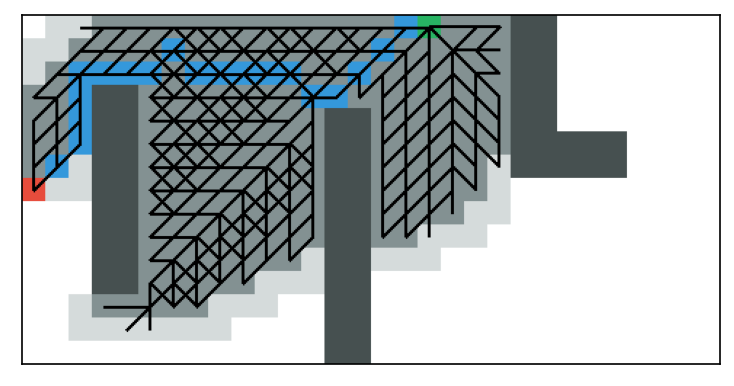

Path found! Length: 29.416. Nodes created: 656. Number of expansions: 178. Transitions computed: 350. Correct: True
CPU times: total: 109 ms
Wall time: 5.48 s


In [12]:
%time res = simple_test(lazy_astar, 5, diagonal_distance, SearchTreePQS)

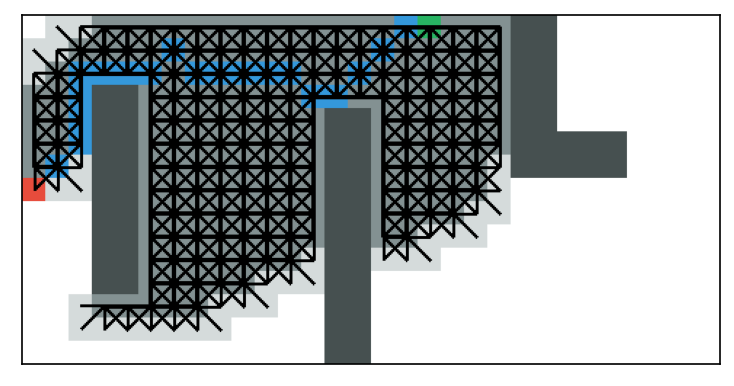

Path found! Length: 29.416. Nodes created: 1238. Number of expansions: 178. Transitions computed: 1238. Correct: True
CPU times: total: 141 ms
Wall time: 19.2 s


In [13]:
%time res = simple_test(astar, 5, diagonal_distance, SearchTreePQS)